<h1><center>Analytical Decision Making Final Report</center></h1>

<h3><center>Team dunnhumby</center></h3>

$$Final=\sum_{TeamMembers=1}^{4} TeamMembers$$

                                        With TeamMembers in (Dane Hamlett,
                                                             Leo Pei,
                                                             Rae Huang, 
                                                             Scott Virshup)
                                                             
                                                             
## Table of Contents
1. [Part One: Description of The Business Problem](#part 1)
1. [Part Two: Definition of the Objective Function, Decision Variables and Constraints](#part 2)
1. [Part Three: An Approach to the Solution](#part 3)

# Part One <a id='part 1'></a>
### Introduction to the Business Problem
As part of the UC Davis MSBA program, our team has been partnered up with dunnhumby, a UK-based customer science company leveraging data to optimize customer loyalty and pricing strategies for global retailers. This partnership is grounded on the execution of a 10-month analytics-based practicum project, aimed at tackling an industry knowledge gap and improving the consumer price perception of one their key clients, Raley’s Supermarkets.

Raley’s Supermarkets is a family-owned grocery chain that currently operates 128 stores in Northern California and Nevada. According to our key stakeholders at dunnhumby, Raley’s has traditionally scored very high with their customers on specific elements of their shopping experience - service, product quality, etc., yet they have also scored very low on price perception. 

While our practicum team has been hard at work identifying the link between consumer price perception, competitor prices, and price elasticities, we have also identified another problem that dunnhumby and Raley's face: determining an optimal price to charge. There are many factors that come into play when setting prices at a grocery store. We hypothesis that if Raley's can identify a way to regularly update prices based on a long-term strategy to maximize revenue, then they will be able to improve their business’s price perception. 

In this jupyter notebook, we explore how to use a relatively simple dynamic programming model to determine what prices should be set for a certain product (we’ve chosen the product “Orange Milanos” as an example) given only a demand function and some initial conditions.

This notebook walks through the logic behind defining the correct objective function, decision variables, and constraints. It explores the data behind the model, creates our own demand function, and then plugs it all into a SciPy minimization solver to determine the optimal prices that will achieve the best revenue.


# Part Two <a id='part 2'></a>
### Definition of the Objective Function, Decision Variables and Constraints

### Objective function:
Raley's has control over their price, but how do different prices influence the unit sales of their products? How can Raley's maximize the revenue by choosing different price levels of their product?

$$Objective: Maximize \sum_{t=1}^{52} (P_{t}\times S_{Pt})$$


### Decision Varables:
For each time period, t, there is a price, P. This means that when we are looking at potentially adjusting price weekly for an entire year, t is an index between 1 and 52. 

Price could have an index per product, but we will simplify this to look at just one product and run our optimization problem on that one product. In this case, we will choose a product from the "COOKIES" category: Orange Milanos. They are Scott's favorite childhood snack and so are a perfect test case.

S(P,t) represents unit sales as a function of price and week. Similarly,

R(P,t) represents revenue as a function of price and week.

### Constraints:
We have to make up some constraints to simplify our model. They are:
* Due to restocking limitations, no single week can sell more than 200 boxes of orange milanos


$$S_{Pt} <= 200$$


* Due to a marketing contract with Pepperidge Farms, Raley's has promised to purchase at least 1500 boxes of orange milanos. If less than this number is sold, Raley's will have to pay for them anyway.


$$\sum_{t=1}^{52} S_{Pt} >= 1500$$


* Raley's contract with Pepperidge Farms also limits the total unit sales for the entire year to be 7,500 boxes due to their manufacturing and supply chain limitations.


$$\sum_{t=1}^{52} S_{Pt} <= 7,500$$


* Non-negativity
    * Price and Demand cannot be negative: 

$$P >= 0$$
 
    
$$S_{Pt} >= 0$$
    

    

### Demand Function:
Having a demand function is another important component of this dynamic optimization problem. In order to map the relationship between price and demand for units sold, we need a demand function that can be used to calculate the demand at any given price. This is critical to know because, from the available data in the Raley's POS system, we only have 1 price point at any given time. Creating a demand function allows us to anticipate how that demand would have changed if we had a slightly different price. An example of such a demand function is below (we do not end up using this exact function in our model):

$$ S(P, t) = \frac{1}{B}\Big(A-P \frac{D}{D+t} \Big)$$

* This equation for demand shows that increasing the week will lead to larger sales figures
* Increasing price will lead to lower demand
* Changing A, B, and D will lead to different demand curves depending on which product is being optimized.
    * Large B will lower demand
    * Large A will increase demand
    * Large D will lower demand
In this equation, units sold is a function of price, week and constants A, B, and D. A, B, and D are constants that can be adjusted depending on the product being analyzed.

We can also adjust this equation slightly to determine price given price, week, and constants of A, B, and D through some simple algebra:

$$ P(S,t) = (A-(B\times S)) \frac{D+t}{D}$$



# Part Three <a id='part 3'></a>
## An Approach to the Solution

## Explore the Data
As part of our practicum project, we have access to the Point Of Sale (POS) transactional data from Raley's supermarkets. In order to understand the problem we are facing in this instance, we directly took price and sales data from Raley's for the product in question. We decided to zoom in on one product in particular so that our results would be more clear to the average user, but this dynamic optimization model can be applied to any of the products in the dataset that Raley's has given us.

Below, we explore the data so that we understand the size and composition of the data that is required for our model.

We see that the data has three key columns:
1. **total_units_sold** This column is intuitively the unit sales for that product during a given time period (in this case, weeks)
1. **avg_active_price** This column was created throughout the work on our practicum and is actually a combination of a number of other columns. This column takes the lowest active price for a given week, and averages out all price points within the system. By "lowest active price," it is understood that Raley's sometimes offers promotional pricing and/or loyalty pricing for certain products; this column will choose whichever one of those prices is lowest (the best deal) and display it.
1. **fiscal_year_week** This column is also broken into two other columns **fiscal_year** and **fiscal_week** which simply add a time-series component to this data.



In [1]:
# Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.optimize as optimize

# Read in the Final Data
milanos = pd.read_csv("https://github.com/svirshup/DynamicProgramming/raw/master/Data/Orange%20Milanos%20Data.csv")

# sort by date
milanos = milanos.sort_values('fiscal_year_week')

# Filter to only include year 2015
milanos = milanos[milanos['fiscal_year'] == 2015]

milanos.head()

,total_units_sold,avg_active_price,fiscal_year_week,fiscal_year,fiscal_week
0,436,3.99,201501,2015,1
1,228,3.99,201502,2015,2
2,461,3.99,201503,2015,3
3,525,3.99,201504,2015,4
4,436,3.99,201505,2015,5


In [2]:
milanos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52 entries, 0 to 51
Data columns (total 5 columns):
total_units_sold    52 non-null int64
avg_active_price    52 non-null float64
fiscal_year_week    52 non-null int64
fiscal_year         52 non-null int64
fiscal_week         52 non-null int64
dtypes: float64(1), int64(4)
memory usage: 2.4 KB


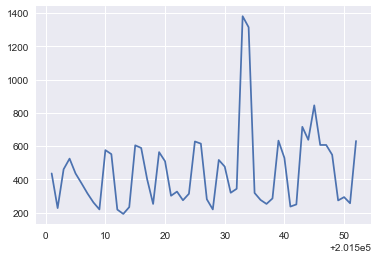

In [3]:
# Let's explore trends in demand

sns.set_style("darkgrid")
plt.plot(milanos['fiscal_year_week'],milanos['total_units_sold'])
plt.show()

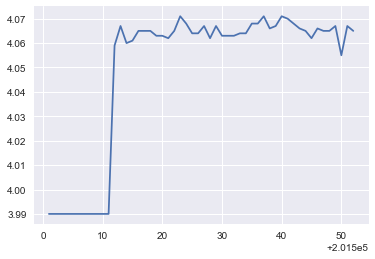

In [4]:
# Let's explore trends in price

sns.set_style("darkgrid")
plt.plot(milanos['fiscal_year_week'],milanos['avg_active_price'])
plt.show()

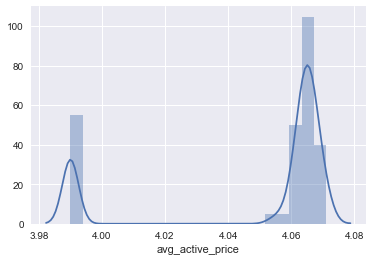

In [5]:
sns.set_style("darkgrid")
sns.distplot(milanos['avg_active_price'])
plt.show()

### Data Improvements

For the simplest model, this is all the data that is necessary. However, as is described later on when talking about the limitations of this model, more datapoints will be necessary when improving the accuracy of the demand function. Some other parameters/model features that are being explored as part of my practicum project, and should be incorporated into future versions of this model are:
1. Holiday flag
    1. A holiday flag will be useful in addressing seasonality that might influence sales
1. Lagged avg price
    1. Another seasonality parameter, having a lagged average price variable will help account for the fact that Raley's often does not change prices, and so their previous prices strongly influence their current sales
1. Competitor pricing
    1. Competitor prices are a major cornerstone of our practicum project, but incorporating them should be done as a log of the difference in prices instead of the actual price of the competition.
    
In addition to those recommendations around which columns should be included, further expanding on the number of data points will also be helpful. This example only uses 52 rows

### Finding a Solution
The logic to find a solution follows that, for a given time period, we will use the demand function to calculate the anticipated demand units sold. Because we are using dynamic programming to solve this problem, the demand will be calculated for each possible price point, and the optimal price level will be determined. This will then be repeated for each time, t, such that we have a matrix of unit sales as a function of price (x-axis) and time (y-axis). This table is shown below for both unit sales demand and revenue:

In [6]:
# libraries
import numpy as np
import pandas as pd
import itertools

from seaborn import heatmap
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)

In [7]:
###### Determining our demand function
# Demand is a function of price. For simplicities sake, we will run a simple regression model to 
# identify this relationship and use the findings in our model for determining demand from a given price
import statsmodels.api as sm

milano_Y = milanos['total_units_sold']
milano_X = milanos['avg_active_price']
#milano_X = milanos.copy()
#columns_to_drop = ['prod_code','prod_name','total_units_sold','fiscal_year_week','fiscal_year','fiscal_week']
#milano_X = milano_X.drop(columns_to_drop,axis=1)

model = sm.OLS(milano_Y,milano_X)
results = model.fit()
results.params

/Users/scottvirshup/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


avg_active_price    111.510202
dtype: float64

In [8]:
# assign our coefficients to objects for reference later
price_coef = results.params['avg_active_price']

# The result of this is counter-intuitive because, in this example, the coefficient is positive 
# when it is expected to be negative.

The demand function is defined as: 

$$ S(P, t) = \frac{PriceCoefficient \times 10 \times t}{P \times t^2}$$

In [9]:
# Define our demand function as described above in the problem statement.
def demand(p, t=np.linspace(1,52,10)):

    return (price_coef*10*t) / (p*t*t)

# Define our price function as described above in the problem statement
def price(x, t=np.linspace(1,52,10)):
    """ Returns the price given a demand x and time t"""

    return (price_coef*10*t) / (x*t*t)

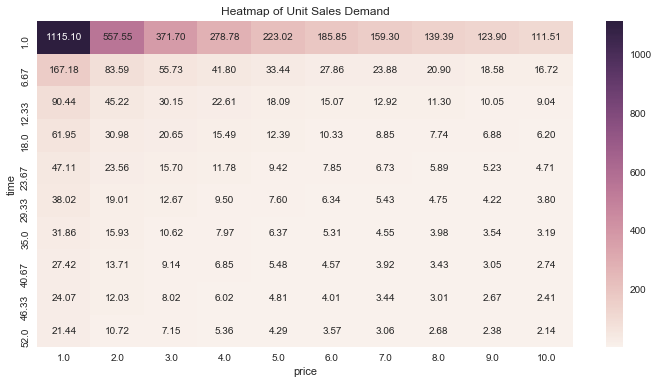

In [10]:
# Unit Sales Demand Matrix
# Defining the heatmap of unit sales demand
t_vals = np.linspace(1,52,10)
p_vals = np.linspace(1,10,10) # test prices in the range 1 through 10
tmp = list(itertools.product(t_vals,p_vals))
rev_df = pd.DataFrame(tmp, columns=['time','price'])
rev_df = rev_df.round(2)
rev_df['demand'] = rev_df.apply(lambda row : demand(row['price'], t=row['time']), axis=1)
rev_df['revenue'] = rev_df.apply(lambda row : row['price']*row['demand'], axis=1)
rev_df_demand = rev_df.pivot('time','price',values='demand')
heatmap(rev_df_demand, annot=True, fmt=".2f")
plt.title('Heatmap of Unit Sales Demand')
plt.show()

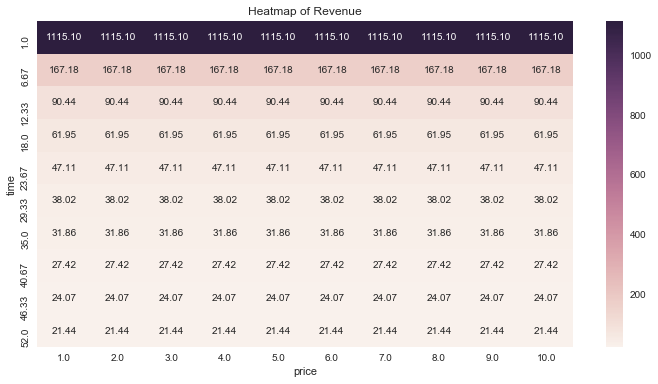

In [11]:
# Heatmap of Revenue
rev_df_revenue = rev_df.pivot('time','price',values='revenue')
heatmap(rev_df_revenue, annot=True, fmt=".2f")
plt.title('Heatmap of Revenue')
plt.show()

### Interpreting Heatmaps
Let's take a moment to break down the heatmaps that we've just created.

The x-axis, price, ranges from 1 dollar to 10 dollars. This range was arbitrarily chosen but essentially acts as a limit for what possible prices I might even consider. I think that 10 is relatively high in this case, but we're leaving it to see how demand seems to trend for this problem across the whole spectrum.

On the y-axis is time, which in the case of our practicum problem, would represent weeks. There are 52 weeks in the year, which is why this ranges from 1 to 52. We've chosen to show only 10 week points along this matrix so it does not become too crowded, but this matrix captures the relationship between time and revenue.

### Optimization

#### Objective Function
Let's define the objective function here. We simply want to maximize price * unit sales. <br>
Since we want to formulate our optimization as a minimization problem, we multiply by -1

In [12]:
# Let's define the objective function here. We simply want to maximize price * unit sales.
# Since we want to formulate our optimization as a minimization problem, we multiply by -1

def objective(x_t, t=np.linspace(1,52,10)):
    """ Objective function takes a vector of demand x_t and
    returns the sum of demand x price for the time period
    of interest.

    We multiply by -1.0 as the optimization routine we will
    use *minimizes* the objective function.
    """
    return -1.0 * np.sum( x_t * price(x_t, t=t) )

#### Constraints
Constraint 1 is the overall inventory constraint
* We have a limited (and non-replenishable) supply of product

Constraint 2 and 3 are non-negative constraints
* Demand and Price cannot be negative

Constraint 5 shows that no single day can sell more than 200 units

Constraint 6 shows that overall unit sales must be at least 1500 units

In [13]:
def constraint_1(x_t):
    return 7500 - np.sum(x_t)


def constraint_2(x_t):
    return x_t


def constraint_3(P):
    return P


def constraint_4(x_t):
    return 200 - x_t


def constraint_5(x_t):
    return np.sum(x_t) - 1500

In [14]:
# Model parameters :
s_0 = 7500.0
t = np.linspace(1,10,10)

# Starting values :
x_start = 3.0 * np.ones(len(t))

# bounds on the values :
bounds = tuple((0,100000.0) for x in x_start)

# Constraints :
constraints = ({'type': 'ineq', 'fun': lambda x: constraint_1(x)},
               {'type': 'ineq', 'fun': lambda x: constraint_2(x)},
               {'type': 'ineq', 'fun': lambda P: constraint_3(P)},
               {'type': 'ineq', 'fun': lambda x: constraint_4(x)},
               {'type': 'ineq', 'fun': lambda x: constraint_5(x)})

#{'type': 'ineq', 'fun':  lambda x, s_0=s_0:  constraint_1(x,s_0=s_0)},

In [15]:
opt_results = optimize.minimize(objective, x_start, args=(t),
                                method='SLSQP', bounds=bounds,  constraints=constraints)

In [16]:
print(opt_results)

     fun: -3266.0984149681794
     jac: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
 message: 'Optimization terminated successfully.'
    nfev: 13
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([150., 150., 150., 150., 150., 150., 150., 150., 150., 150.])


In [17]:
np.sum(opt_results['x'])

1499.9999999599413

In [18]:
print( price(opt_results['x'], t=t) )

[7.43401346 3.71700673 2.47800449 1.85850337 1.48680269 1.23900224
 1.06200192 0.92925168 0.8260015  0.74340135]


### Interpretation of the output

The last array of numbers (see appendix “model output”) were the suggested price points for the 10 weeks that the model interpreted. We could have had the model suggest 52 prices (1 per week), but having 10 price points is more realistic and comparable to the real world because Raley's cannot realistically change their price every week. 10 price points is something that our stakeholders at dunnhumby agree is in-line with how quickly a supermarket can change their display pricing and POS system relationships.

We find that these prices decrease over time. This outcome is expected due to our demand model decreasing demand as time marches steadily onward. This aspect of the demand model would also make sense if our product showed seasonal variations, or if the product was part of a one-time promotion (for instance, if it was a branded promotional product that sponsored a movie).

Prices start at approximately 7 dollars and 43 cents, and decline to about 75 cents. This optimization model also predicts that we should expect to sell 1500 units of these cookies over the course of these 10 weeks by using these price points. However, those 1500 units are calculated as the total unit sales from just the 10 weeks that were calculated, in reality there will be 52 total weeks instead of 10, so we could expect this figure to be much larger.



## Limitations of this model
Such a dynamic model requires both the accurate definition of the constraints that our model will operate under as well as the accurate definition of demand. In our example, demand is defined very generally and so does not precisely represent how price will influence unit sales. Instead, we should improve the model in the future first by spending time to collect additional data on marketing efforts, seasonality, competitor prices, and other columns in order to refine our demand function. As part of our practicum team, we will further expand upon this by asking our dunnhumby stakeholders what their demand functions currently are, and see how closely they align to what we've created ourselves.

We made many assumptions that made this problem solvable with the limited data that we have, but that also means that it is less representative of the real world. As the famous saying goes, "all models are wrong, but some are useful." This wise saying is what should be considered if one uses this model to make pricing decisions in the future.


References:
* http://isaacslavitt.com/2014/06/20/linear-optimization-in-python/
* https://www.datascience.com/resources/notebooks/python-dynamic-pricing